<a href="https://colab.research.google.com/github/shown5/HandsOnLLM/blob/main/chap9_multimodal_llm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install matplotlib transformers datasets accelerate sentence-transformers

In [ ]:
from urllib.request import urlopen
from PIL import Image

# 雪の中で遊ぶ子犬のAI生成画像を読み込む
puppy_path = "https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/chapter09/images/puppy.png"
image = Image.open(urlopen(puppy_path)).convert("RGB")

caption = "a puppy playing in the snow"

In [ ]:
from transformers import CLIPTokenizerFast, CLIPProcessor, CLIPModel

model_id = "openai/clip-vit-base-patch32"

# テキストを前処理するためのトークナイザーを読み込む
clip_tokenizer = CLIPTokenizerFast.from_pretrained(model_id)

# 画像を前処理するためのプリプロセッサーを読み込む
clip_processor = CLIPProcessor.from_pretrained(model_id)

# テキストと画像の埋め込みを生成するためのメインモデルを読み込む
model = CLIPModel.from_pretrained(model_id)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

In [ ]:
# テキストをトークン化する
inputs = clip_tokenizer(caption, return_tensors="pt")
inputs

{'input_ids': tensor([[49406,   320,  6829,  1629,   530,   518,  2583, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}

In [ ]:
# トークンIDをテキストに変換する
clip_tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

['<|startoftext|>',
 'a</w>',
 'puppy</w>',
 'playing</w>',
 'in</w>',
 'the</w>',
 'snow</w>',
 '<|endoftext|>']

In [ ]:
# テキスト埋め込みを生成する
text_embedding = model.get_text_features(**inputs)
text_embedding.shape

torch.Size([1, 512])

In [ ]:
# 画像を前処理する
processed_image = clip_processor(
    text=None, images=image, return_tensors="pt"
)["pixel_values"]

processed_image.shape

torch.Size([1, 3, 224, 224])

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

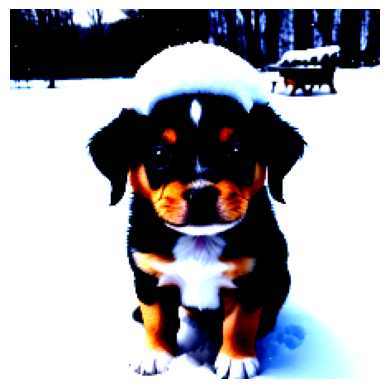

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# 画像を可視化するための準備
img = processed_image.squeeze(0)
img = img.permute(*torch.arange(img.ndim - 1, -1, -1))
img = np.einsum("ijk->jik", img)

# 前処理された画像を可視化する
plt.imshow(img)
plt.axis("off")

In [ ]:
# 画像埋め込みを生成する
image_embedding = model.get_image_features(processed_image)
image_embedding.shape

torch.Size([1, 512])

In [ ]:
# 埋め込みを正規化する
text_embedding /= text_embedding.norm(dim=-1, keepdim=True)
image_embedding /= image_embedding.norm(dim=-1, keepdim=True)

# 類似度を計算する
text_embedding = text_embedding.detach().cpu().numpy()
image_embedding = image_embedding.detach().cpu().numpy()
score = np.dot(text_embedding, image_embedding.T)
score

array([[0.33149645]], dtype=float32)

In [ ]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration
import torch

# プロセッサーとメインモデルを読み込む
blip_processor = AutoProcessor.from_pretrained(
    "Salesforce/blip2-opt-2.7b",
    revision="51572668da0eb669e01a189dc22abe6088589a24"  # Choose specific model because of: https://huggingface.co/Salesforce/blip2-opt-2.7b/discussions/39
)
model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-opt-2.7b",
    revision="51572668da0eb669e01a189dc22abe6088589a24",
    torch_dtype=torch.float16
)

# 推論を高速化するためにモデルをGPUに送る
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/904 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/5.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Blip2ForConditionalGeneration(
  (vision_model): Blip2VisionModel(
    (embeddings): Blip2VisionEmbeddings(
      (patch_embedding): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
    )
    (encoder): Blip2Encoder(
      (layers): ModuleList(
        (0-38): 39 x Blip2EncoderLayer(
          (self_attn): Blip2Attention(
            (qkv): Linear(in_features=1408, out_features=4224, bias=True)
            (projection): Linear(in_features=1408, out_features=1408, bias=True)
          )
          (layer_norm1): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
          (mlp): Blip2MLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1408, out_features=6144, bias=True)
            (fc2): Linear(in_features=6144, out_features=1408, bias=True)
          )
          (layer_norm2): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
  )
  (qf

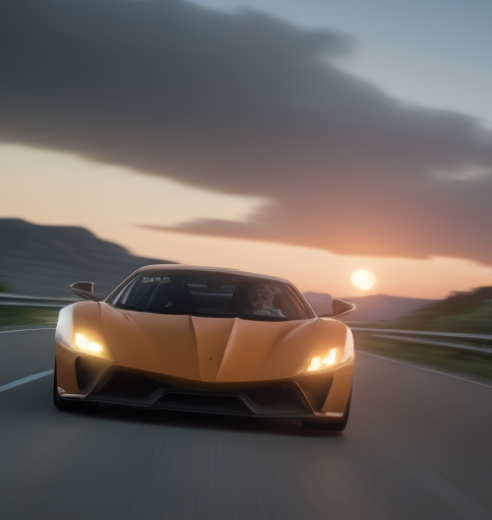

In [ ]:
# スーパーカーの画像を読み込む
car_path = "https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/chapter09/images/car.png"
image = Image.open(urlopen(car_path)).convert("RGB")

image

In [ ]:
# 画像を前処理する
inputs = blip_processor(image, return_tensors="pt").to(device, torch.float16)
inputs["pixel_values"].shape

torch.Size([1, 3, 224, 224])

In [ ]:
blip_processor.tokenizer

GPT2TokenizerFast(name_or_path='Salesforce/blip2-opt-2.7b', vocab_size=50265, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '</s>', 'eos_token': '</s>', 'unk_token': '</s>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	50265: AddedToken("<image>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [ ]:
# テキストを前処理する
text = "Her vacalization was reamrkably melodic"
token_ids = blip_processor(image, text=text, return_tensors="pt")
token_ids = token_ids.to(device, torch.float16)["input_ids"][0]

# 入力IDをトークンに戻す
tokens = blip_processor.tokenizer.convert_ids_to_tokens(token_ids)

In [ ]:
# スペーストークンをアンダースコアに置き換える
tokens = [token.replace("G", "_") for token in tokens]
tokens

['</s>',
 'Her',
 'Ġvac',
 'al',
 'ization',
 'Ġwas',
 'Ġre',
 'am',
 'r',
 'k',
 'ably',
 'Ġmel',
 'odic']

Keyword argument `return_tensor` is not a valid argument for this processor and will be ignored.


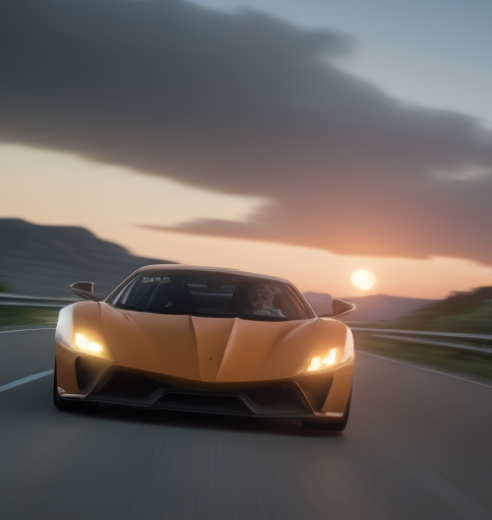

In [ ]:
# AI が生成したスーパーカーの画像を読み込む
image = Image.open(urlopen(car_path)).convert("RGB")

# 画像を入力に変換して前処理する
inputs = blip_processor(image, return_tensor="pt").to(device, torch.float16)
image

In [ ]:
# デコーダー（LLM）に渡すための画像IDを生成する
generated_ids = model.generate(**inputs, max_new_tokens=20)

# 画像IDからテキストを生成する
generated_text = blip_processor.batch_decode(
    generated_ids, skip_special_tokens=True
)
generated_text = generated_text[0].strip()
generated_text

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
# ロールシャッハテストの画像を読み込む
url = "https://upload.wikimedia.org/wikipedia/commons/7/70/Rorschach_blot_01.jpg"
image = Image.open(urlopen(url)).convert("RGB")

# キャプションを生成する
inputs = blip_processor(image, return_tensors="pt").to(device, torch.float16)
generated_ids = model.generate(**inputs, max_new_tokens=20)
generated_text = blip_processor.batch_decode(
    generated_ids, skip_special_tokens=True
)
generated_text = generated_text[0].strip()
generated_text

In [ ]:
# AI が生成したスーパーカーの画像を読み込む
image = Image.open(urlopen(car_path)).convert("RGB")

In [ ]:
# 視覚的質問応答
prompt = "Question: Write down what you see in this picture. Answer:"

# 画像とプロンプトの両方を処理
inputs = blip_processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)

# テキストを生成
generated_ids = model.generate(**inputs, max_new_tokens=30)
generated_text = blip_processor.batch_decode(
    generated_ids, skip_special_tokens=True
)
generated_text = generated_text[0].strip()
generated_text

In [ ]:
# チャット形式のプロンプト
prompt = "質問：この画像で見えるものと書き出してください。回答：夕焼けの中、道路を走るスポーツカー。質問：このような車を運転するには何が必要ですか？回答："
# 出力を生成
inputs = blip_processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)
generated_ids = model.generate(**inputs, max_new_tokens=30)
generated_text = blip_processor.batch_decode(
    generated_ids, skip_special_tokens=True
)
generated_text = generated_text[0].strip()
generated_text

In [ ]:
from IPython.display import HTML, display
import ipywidgets as widgets

def text_eventhandler(*args):
  question = args[0]["new"]
  if question:
    args[0]["owner"].value = ""

    # プロンプトを作成
    if not memory:
      prompt = "Question: " + question + "Answer: "
    else:
      template = "Question: {} Answer: {}."
      prompt = " ".join(
          [
              template.format(memory[i][0], memory[i][1])
              for i in range(len(memory))
          ]
      ) + " Question: " + question + " Answer:"
    # テキストを生成
    inputs = blip_processor(image, text=prompt, return_tensors="pt")
    inputs = inputs.to(device, torch.float16)
    genearted_ids = model.generate(**inputs, max_new_tokens=100)
    generated_text = blip_processor.batch_decode(
        generated_ids,
        skip_special_tokens=True
    )
    generated_text = generated_text[0].strip().split("Question")[0]

    # メモリの更新
    memory.append((question, generated_text))

    # 出力を割り当て
    output.append_display_data(HTML("<b>USER:</b> " + question))
    output.append_display_data(HTML("<b>BLIP-2:</b> " + generated_text))
    output.append_display_data(HTML("<br>"))

# ウィジェットを準備
in_text = widgets.Text()
in_text.continuous_update = False
in_text.observe(text_eventhandler, "value")
output = widgets.Output()
memory = []

# チャットボックスを表示
display(
    widgets.VBox(
        children=[output, in_text],
        layout=widgets.Layout(display="inline-flex", flex_flow="column-reverse"),
    )
)